# Plant seedlings: determining plant species using image classification

## Introduction
<p> The ability to identify plant species effectively can facilitate better crop yields and responsible use of the environment. This can help in differentiating weeds from crop seedlings.</p>


### Objective
<ol>
    <li>Build a convolutional neural network for classifying plant seedlings.</li>
    <li>Analysis of the model and strategies to improve the model.</li>

### Data Information/Variables
<p> <strong>images.npy</strong> - numpy array containing images of the plant seedlings<br>
    <strong>labels.csv</strong> - labels corresponding to the plants in the images<br>
    </p>

### The analysis below has the following sections:
<ol>
    <li> Loading and importing packages </li>
    <li> Removing warnings from python notebooks </li>
    <li> Loading the dataset </li>
    <li> Printing images from each class with their corresponding labels </li>
    <li> Exploratory data analysis - mean images, distribution of classes </li>
    <li> Data preprocessing/model preparation - removing noise (gaussian blurring), normalizing the data, splitting the data into train and test, plotting images before and after preprocessing, label encoding. </li>
    <li> <strong>Convolutional neural network</strong> - building the convolutional neural network model</li>
    <li> <strong>Convolutional neural network performance improvement </strong> - analysis of model performance, improvement of the model</li>
    <li> Summary and key takeaways - final conclusions and summary of the analysis </li>

## 1. Loading and importing packages

In [1]:
# Import the necessary packages
import numpy as np #the images are numpy arrays and for performing computations
import pandas as pd #for use with dataframes
import matplotlib.pyplot as plt #for images and data visualization
import seaborn as sns #for data visualization
# library for reading and showing images
import matplotlib.image as mpimg


sns.set(color_codes=True)  # For background of the graphs
%matplotlib inline

from sklearn.model_selection import train_test_split # to split the data into training and test sets

import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # for different layers of CNN
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

import keras
from tensorflow.keras import optimizers
from keras import backend as K

#This is to reduce the variation in the results everytime the notebook is run
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

from sklearn.utils import class_weight
# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
)


# library for creating data paths
import os

# library for randonly selecting data points
import random

# importing all the required sub-modules from keras
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import cv2 as cv


from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping #regularization methods
from keras.callbacks import ModelCheckpoint

#Reading the training images from the path and labelling them into the given categories


import os
 

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K

from keras.layers import  MaxPool2D
from tensorflow.keras.optimizers import Adam #optimiers for optimizing the model

from tensorflow.keras.models import Model
from tensorflow.keras import losses, optimizers


### 2. Removing warnings from python notebook

In [2]:
# Removing warnings from the notebook
import warnings

warnings.filterwarnings("ignore")

### 3. Loading the dataset

In [3]:
# The data is in two sets: (a) images as a numpy array and (b) the labels are in a dataframe. 
# There is one to one correspondence between the images index and label index. 
images = np.load("images.npy")
labels = pd.read_csv("Labels.csv")

In [4]:
#Checking the shape of the labels dataset
print(f"The dataframe has {labels.shape[0]} rows and {labels.shape[1]} columns.")

The dataframe has 4750 rows and 1 columns.


#### Observations
<p>The labels dataframe has only one column (that will contain the name of the plant seedling where there is one to one correspondence between the index of the labels dataframe and the index of the image dataset). There are 4750 rows, so there will be 4750 images in the "images" dataset. </p>


In [5]:
# Checking the shape of the images dataset 
print('The shape of the image is:',images.shape)
h,w = images.shape[1:3]
print("Height = {}, Width = {}".format(h,w))

The shape of the image is: (4750, 128, 128, 3)
Height = 128, Width = 128


#### Observations 
<p> There are 4750 images in all. The images are in RGB (having 3 channels/colors) and are 128 x 128. </p>

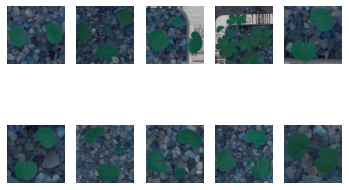

In [6]:
plt.close('all')
# Displaying some images as a preview
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    plt.axis('off')
 

#### Observations
<p> In the above preview, the first 10 images in the data set are displayed. The images are numpy arrays and can be viewed using matplotlib's imshow function. We can observe above that the green parts in the images are plants/seedlings and the background has some pebbles, as well as paper labels. Overall, the images do not have much contrast between the seedlings and the pebbles as they are both dark colors. The number of leaves in each image is different in number and shape. </p>


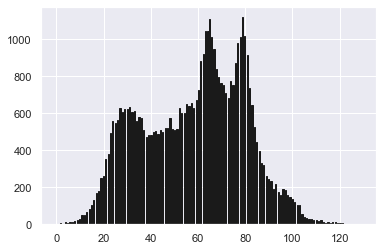

(-0.5, 127.5, 127.5, -0.5)

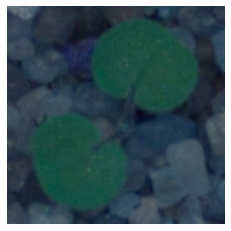

In [7]:
# Plotting the histogram of a sample image
img1 = images[200,:,:,:]
plt.hist(img1.ravel(),bins=256,fc='k',ec='k')
plt.show()
plt.imshow(img1)
plt.axis('off')

#### Observations
<p> The histogram shows that the peak is in the middle, and not much useful information at the right tail. The image has multiple peaks.</p>

In [8]:
#Preview of the labels dataframe
labels.head()

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

#### Observations
<p> The labels dataframe has a column "Label" and has string labels which correspond to the name of the plant seedlings in the images. </p>

In [9]:
# Finding the sum total of missing values in each of the columns
labels.isnull().sum().sort_values(ascending=False)

Label    0
dtype: int64

#### Observations
<p> There are no missing values in the labels dataset. </p>

In [10]:
# Before starting preprocessing, a look at summary statistics
labels.describe().T  # taking transpose since it is easier to view

count unique               top freq
Label  4750     12  Loose Silky-bent  654

#### Observations
<p> There are 12 unique labels in the dataset. The top label is "Loose Silky-bent" and occurs 654 times in the dataset. </p>

In [11]:
#Descriptive statistics on the label dataset
labelCount = pd.crosstab(index=labels["Label"],columns="count")
labelCount

col_0                      count
Label                           
Black-grass                  263
Charlock                     390
Cleavers                     287
Common Chickweed             611
Common wheat                 221
Fat Hen                      475
Loose Silky-bent             654
Maize                        221
Scentless Mayweed            516
Shepherds Purse              231
Small-flowered Cranesbill    496
Sugar beet                   385

#### Observations
<p> As we saw earlier, the 'Loose Silky-bent' occurs most frequently in the dataset. Maize and Common wheat have the lowest counts. Some of the labels have multiple words, and some words are separated with a hyphen. We will be encoding the labels column while preparing the data for the models. </p>

### 4. Printing images from each class with their corresponding labels

In [10]:
# to print images from each class, we shall group the labels by the name
# and then use the index to find the corresponding images in the image dataset
Black_grass = labels[labels['Label'] == 'Black-grass'].index
Charlock = labels[labels['Label'] == 'Charlock'].index
Cleavers = labels[labels['Label'] == 'Cleavers'].index
Common_Chickweed = labels[labels['Label'] == 'Common Chickweed'].index
Common_wheat = labels[labels['Label'] == 'Common wheat'].index
Fat_Hen = labels[labels['Label'] == 'Fat Hen'].index
Loose_Silky_bent = labels[labels['Label'] == 'Loose Silky-bent'].index
Maize = labels[labels['Label'] == 'Maize'].index
Scentless_Mayweed = labels[labels['Label'] == 'Scentless Mayweed'].index
Shepherds_Purse = labels[labels['Label'] == 'Shepherds Purse'].index
Small_flowered_Cranesbill = labels[labels['Label'] == 'Small-flowered Cranesbill'].index
Sugar_beet = labels[labels['Label'] == 'Sugar beet'].index

In [11]:
#Putting all the labels into a column for displaying the images
cols = [Black_grass[1],Charlock[1],Cleavers[1],Common_Chickweed[1],Common_wheat[1],Fat_Hen[1],Loose_Silky_bent[1]
       ,Maize[1],Scentless_Mayweed[515],Shepherds_Purse[1],Small_flowered_Cranesbill[1],Sugar_beet[1]]

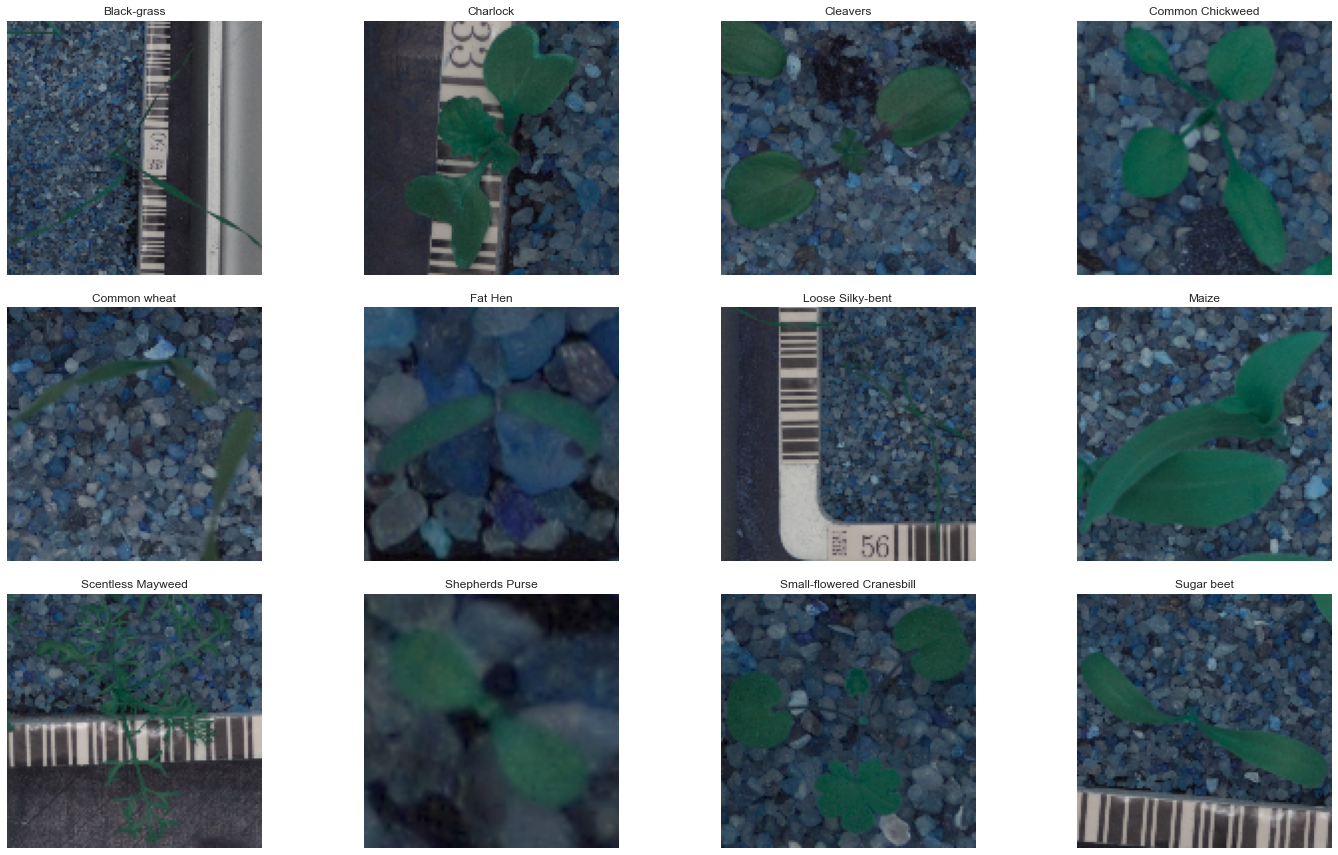

In [16]:
# Displaying images from each class along with their corresponding labels
y = labels["Label"]
plt.figure(figsize=(20, 20))

for i, variable in enumerate(cols):
    plt.subplot(5, 4, i + 1)
    new_image1 = images[variable,:,:,:]
    plt.imshow(new_image1)
    plt.title(y[variable])
    plt.tight_layout()
    plt.axis('off')
  

plt.show()

#### Observations
<p> As observed earlier, all the images are bluish-green and some images have a black and white strip in them (likely barcode). All the plant seedlings are green, and the pebbles in the background are mostly bluish. Some of the plant seedlings have broad leaves, while some of them have very narrow and thin leaves. </p>

### 5. Exploratory data analysis - mean images, distribution of classes

<AxesSubplot:xlabel='Label', ylabel='count'>

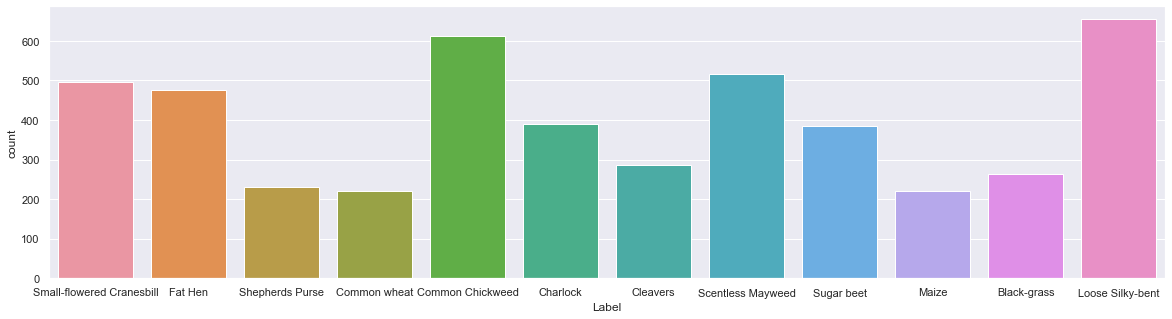

In [12]:
# A countplot of the distribution of images within the 12 label sets
sns.set(rc={'figure.figsize':(20,5)})
sns.countplot(x="Label", data=labels)


#### Observations
<p> As observed earlier, the largest number of images are for "Loose Silky-bent" which is a plant seedling (about 13% of the data). This is followed by "Common Chickweed". While "Loose Silky-bent" is a plant seedling, the "Common Chickweed" is a weed. Since the main aim of developing the model is to be able to be able to identify whether a sample is a plant and weed (to facililate the process of crop yields), these two classes have a fairly good distribution (i.e. high number of examples) within the dataset. <br>
<p> We can also observe that there is no label class that does not have any images. "Maize" and "Common wheat" have the lowest number of images (~4%). </p>
<p> Overall, the class distribution looks fairly even, with sufficient examples for each class. </p>

In [13]:
#for i, variable in enumerate(cols):
#    gray = cv.cvtColor(images[variable],cv.COLOR_BGR2GRAY)
#    gray = cv.resize(gray,(150,150))

In [14]:
def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 1)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((128,128))
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

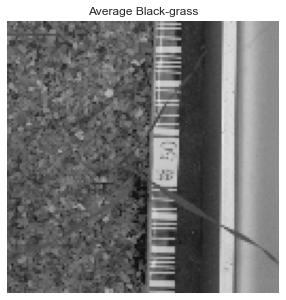

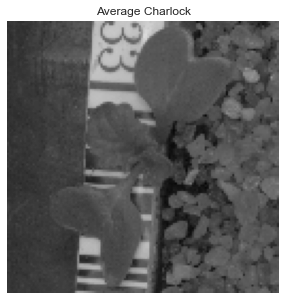

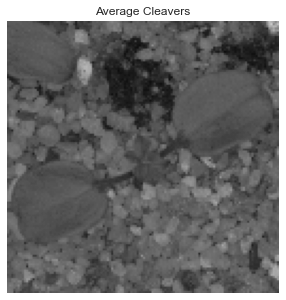

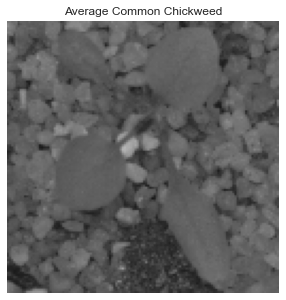

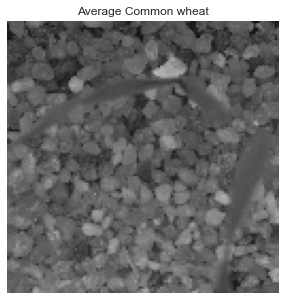

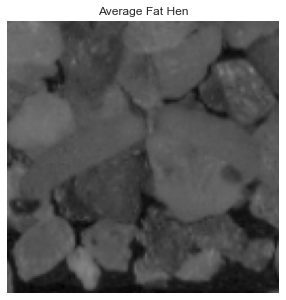

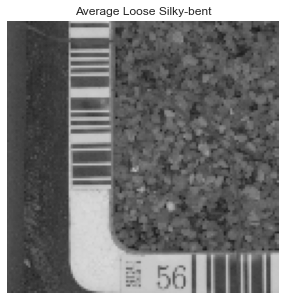

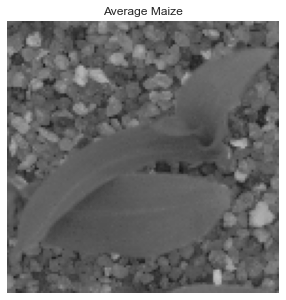

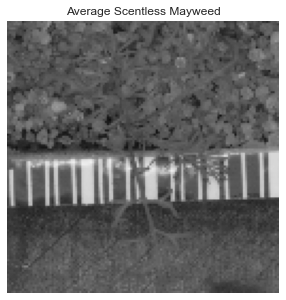

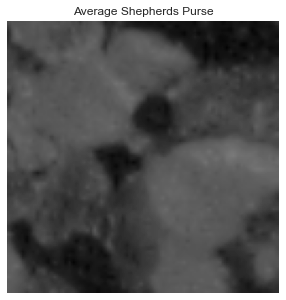

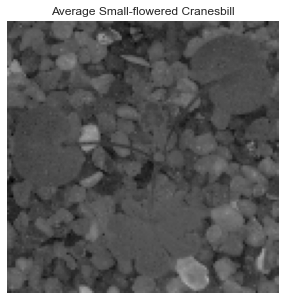

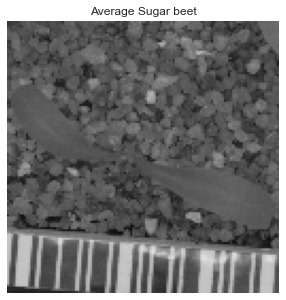

In [17]:

for i, variable in enumerate(cols):
    test = []
    new_image1 = images[variable,:,:,:]
    graynew_image1 = cv.cvtColor(new_image1,cv.COLOR_BGR2GRAY)
    graynew_image2 = cv.resize(graynew_image1,(128,128))
    test.append([graynew_image2])
    test2 = np.array(test)
    title = y[variable]
    new_image2 = find_mean_img(test2,title)

#### Observations and insights 
<p> <ol>
    <li>In the above images, the mean value of the pixels that was taken along an axis has been plotted. As we can see, even though the average pixel values are plotted, they are close to the actual distribution of the pixel values because we can see the plant seedlings in the images. </li>
    <li> The images were converted to grayscale (reduction in dimensions). This will help with execution of the models later on as the 128x 128 x 3 image is reduced to 128 x 128 while preserving edge information which will be important in the training of the model, while reducing the time needed to run the models. </li>
    <li> We do not see any significant difference in the mean images for plant seedlings and weeds (e.g. maize mean image versus common chickweed. This can be interpreted that weeds and edible crops have the same color distribution (on a grayscale) - for example, if maize is a certain color in the grayscale, then the weed species are also likely to fall on that same grayscale distribution. This does make the classification tougher as the color distribution cannot be relied upon as a distinguishing feature. </li>

### 5. Data preprocessing/model preparation 

#### This section will have the following subsections
<p>
        <ol><li> removing noise (gaussian blurring)</li>
        <li>  splitting the data into train and test</li>
        <li> labels encoding</li>
        <li> normalizing the data</li>
       </ol></p>

In [18]:
# Section 5.1  Removing noise (gaussian blurring)
# To demonstrate an example of gaussian blurring, we will take a sample image and show the 
# before and after image 
sample_image = images[Maize[1],:,:,:]

Original Image:



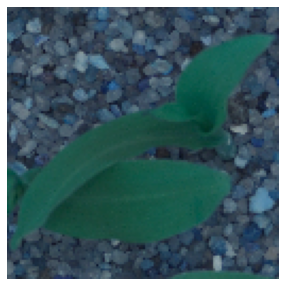


 Output after first gaussian blurring: 



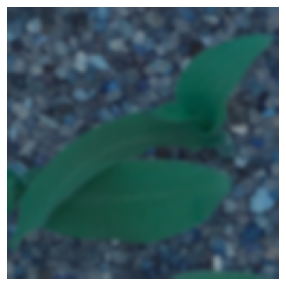


 Output after second gaussian blurring: 



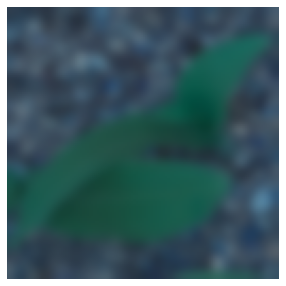

In [19]:
Gaussian1 = cv2.GaussianBlur(sample_image, (5, 5), 0)
Gaussian2 = cv2.GaussianBlur(sample_image, (15, 15), 0)
print('Original Image:\n')
plt.imshow(sample_image)
plt.axis('off')
plt.show()
print('\n Output after first gaussian blurring: \n')
plt.imshow(Gaussian1)
plt.axis('off')
plt.show()
print('\n Output after second gaussian blurring: \n')
plt.imshow(Gaussian2)
plt.axis('off')
plt.show()

#### Observations
<p> Gaussian blurring uses low pass filters to help smooth the image. The details of the object under consideration are smoothened over (hidden). As we can observe in the above images, the maize details in the first image are reduced in the third image (the central vein of the leaf. This can be advantageous for deep learning algorithms. </p>

In [20]:
# Section 5.2 Splitting the dataset
# We will be using the gray scale images here as part of preprocessing
newgrayimages = []
for i in labels.index:
    grayimages = cv.cvtColor(images[i,:,:,:],cv.COLOR_BGR2GRAY)
    newgrayimages.append(grayimages)
    newgrayimages1 = np.array(newgrayimages)


In [34]:
#Also applying gaussian blurring to remove noise from the color images
newblurimages = []
for i in labels.index:
#Gaussian1 = cv.GaussianBlur(sample_image, (5, 5), 0)
    Gaussianblurimages = cv.GaussianBlur(images[i,:,:,:], (15, 15), 0)
    newblurimages.append(Gaussianblurimages)
    newblurimages1 = np.array(newblurimages)

In [35]:
#Checking the shape of the array for gaussian blur images
newblurimages1.shape

(4750, 128, 128, 3)

#### Observations
<p> The RGB image was 128 x 128 x 3, and there were 4750 images. Here, the dataset is converted to 128 x 128 and there are 4750 images in all at the end of conversion to gray scale. The grayscale images are displayed below. However, when we compare the grayscale images to the RGB images, a visual inspection shows that the RGB images after blurring retain good contrast where the plant seedlings are more identifiable as compared to the background. Hence, we shall use RGB images for the model. </p>

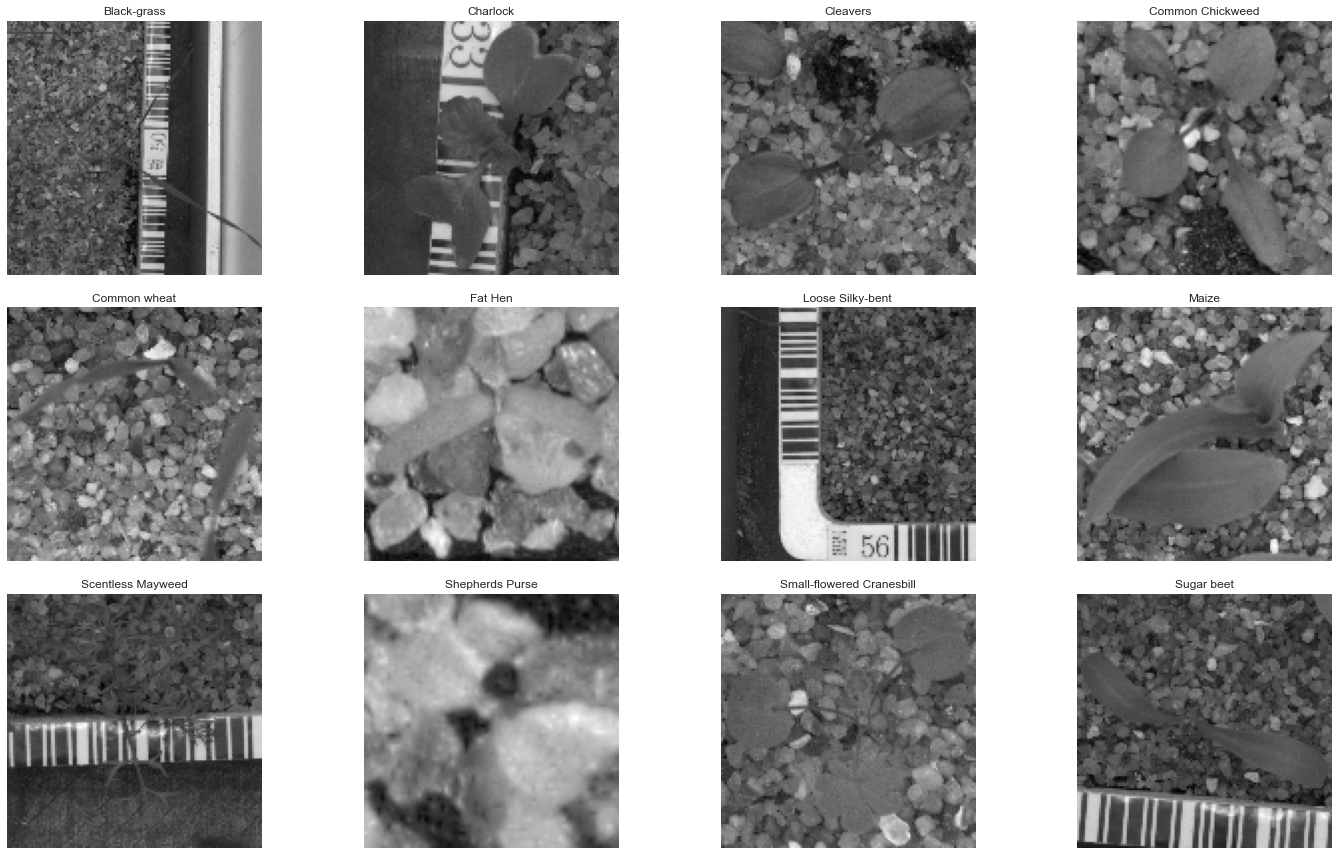

In [22]:
# Displaying grayscale images in each class with their corresponding labels
y = labels["Label"]
plt.figure(figsize=(20, 20))

for i, variable in enumerate(cols):
    plt.subplot(5, 4, i + 1)
    new_image1 = newgrayimages1[variable,:,:]
    plt.imshow(new_image1,cmap='gray')
    plt.title(y[variable])
    plt.tight_layout()
    plt.axis('off')
  

plt.show()

#### Observation
<p> The gray scale images match up with the original images, except they have reduced dimension and have pixels from 0 - 255 in grayscale. </p>

In [38]:
# splitting the dataset
# We are not using grayscale images, but gaussian blurred images with RGB channels
X_train, X_test, y_train, y_test = train_test_split(newblurimages1,labels , test_size=0.1, random_state=10,stratify=y)

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4275, 128, 128, 3)
(4275, 1)
(475, 128, 128, 3)
(475, 1)


#### Observations
<p> We have used a test_size of 0.1, so the training dataset has 4275 images and the test data set has 475 images. The labels dataset has one column, while the images are 128 x 128 x 3(RGB). </p>

In [40]:
#Section 5.3: Label encoding
#We will use label encoding for the labels dataset as to_categorical requires numerical input
enc = LabelBinarizer()
y_train_e = enc.fit_transform(y_train)
enc_test = LabelBinarizer()
y_test_e= enc.fit_transform(y_test)

In [41]:
#Checking shape of the labels dataset after encoding
print(y_train_e.shape)

print(y_test_e.shape)

(4275, 12)
(475, 12)


#### Observations
<p> The labels dataset has been encoded to 12 classes. </p>

In [42]:
#Section 5.4: Normalizing the images
# We normalize the images so that larger pixel values do not influence the model 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train_n = X_train / 255
X_test_n = X_test/255

In [43]:
X_train_final = X_train_n.reshape(X_train_n.shape[0], 128, 128, 3)
X_test_final = X_test_n.reshape(X_test_n.shape[0], 128, 128, 3)

In [44]:
print("X_train shape:", X_train_final.shape)
print("Images in X_train:", X_train_final.shape[0])
print("Images in X_test:", X_test_final.shape[0])
print("Max value in X_train:", X_train_final.max())
print("Min value in X_train:", X_train_final.min())

X_train shape: (4275, 128, 128, 3)
Images in X_train: 4275
Images in X_test: 475
Max value in X_train: 0.972549
Min value in X_train: 0.0


#### Observations
<p> There are 4275 images in the training set and 475 images in the test set. The maximum value after normalization is 1 for training set and minimum value is 0 in the training set. The training set and testing images have been reshaped so that they are compatible with keras model building. This concludes the preprocessing of the dataset for the deep learning models. </p>

### 6. Convolutional neural network - building the convolutional neural network model

#### CNN model 1 
<p> The first model that can be built for analysis can be a simple model. This model will have 2 convolution layers and ReLu activation function will be used for the layers. This is a multiple classification problem, so the output layer (using a softmax function for probabilities) will 12 classes. </p>

<p> Note about model predictions </p>
<p> This is a multiple classification problem as there are 12 classes in the target variable. </p>
<p> However, overall some of the classes are weeds, and some are edible crops. As the ultimate aim of the
    data analysis is to increase crop yield and removing weeds, we can use an example of maize and common chickweed
    to determine which metric would be useful to us. </p>
<p> If the model predicts that image A (example) is maize, and the image is maize (this is supervised learning so we know the outcome), this is a true positive. </p>
 <p> If the model predicts that image A (example) is common chickweed (a weed), and the image is maize (this is supervised learning so we know the outcome), this is a false negative (FN). </p>
 <p> If the model predicts that image A (example) is maize, and the image not maize then this is a false positive(FP). </p>
<p> To evaluate which performance metric is most valuable for the analysis, we have to consider</p>
<p> (a) Predicting that a plant seedling is maize, but it is not - likelihood that weeds have been missed and will compete with crops for resources (false positive)</p>
<p> (b) Predicting that a plant seedling is not maize, but it is maize - loss of actual crop(false negative)</p>
<p> In general, we do not want to lose actual crops, but we also want to get rid of weeds - so for this particular case, accuracy (proportion of correctly classified photos) will be a useful metric. </p>

In [45]:
#Initialize the model
model = Sequential()

In [46]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128,3)))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="softmax"))

In [47]:
# Compile the model
# The optimizer will update the weights for the above model
# 'adam' optimizer uses stochastic gradient technique to update the weights
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
history = model.fit( x=X_train_final, y=y_train_e, batch_size=10, epochs=5, validation_split = 0.3)

Epoch 1/5
300/300 [==============================] - 154s 507ms/step - loss: 2.2458 - accuracy: 0.3229 - val_loss: 1.8771 - val_accuracy: 0.4217
Epoch 2/5
300/300 [==============================] - 187s 625ms/step - loss: 1.6517 - accuracy: 0.4920 - val_loss: 1.7112 - val_accuracy: 0.4770
Epoch 3/5
300/300 [==============================] - 185s 617ms/step - loss: 1.3742 - accuracy: 0.5598 - val_loss: 1.6560 - val_accuracy: 0.4918
Epoch 4/5
300/300 [==============================] - 176s 586ms/step - loss: 1.1667 - accuracy: 0.6136 - val_loss: 1.5584 - val_accuracy: 0.5253
Epoch 5/5
300/300 [==============================] - 172s 575ms/step - loss: 1.0200 - accuracy: 0.6578 - val_loss: 1.5098 - val_accuracy: 0.5105


#### Observations
<p> The CNN Model 1 is a simplistic model with 2 convolution layers. The hidden layer neurons was kept between the input image size and the output layer size (i.e. between 12 and 128). As we can see, the accuracy after 5 epochs was 65%.</p>

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 flatten_1 (Flatten)         (None, 492032)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                31490112  
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 31,501,036
Trainable params: 31,501,036
Non-trainable params: 0
_________________________________________________________________


#### Observation
<p> We can see that the non-trainable parameters are 0. The CNN had 2 dense layers, out of which one was the output layer with 12 neurons. </p>

In [49]:
model.evaluate(X_test_final, y_test_e)

15/15 [==============================] - 3s 194ms/step - loss: 1.4945 - accuracy: 0.5137


[1.4944758415222168, 0.5136842131614685]

#### Observations
<p> When CNN Model 1 was evaluated on the test set, the accuracy was 51%. This is compared to the training data set where the accuracy was 65%. The model can be further improved as shown in CNN Model 2 and CNN Model 3. </p>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


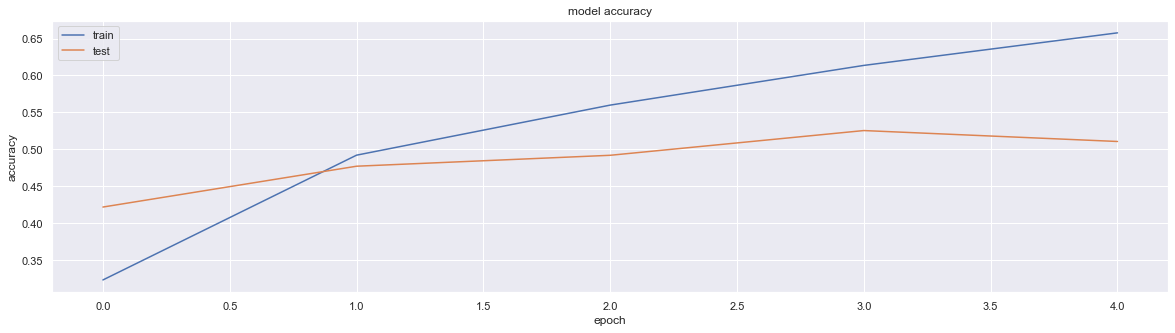

In [50]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### Observations
<p> The blue curve is the visualization of the loss curve for training and the red curve is for test. Both curves are close to each other so overfitting is unlikely.</p>

In [51]:
# Test Prediction 
y_test_pred= model.predict(X_test_final)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.argmax(y_test_pred, axis=1)

In [52]:
y_test_e1 = np.argmax(y_test_e,axis=1)

In [53]:
# Test Accuracy 

from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test_e1, y_test_pred_classes)


0.5136842105263157

In [56]:
#Putting all the labels into a column for confusion matrix
colsnew = ['Black_grass','Charlock','Cleavers','Common_Chickweed','Common_wheat','Fat_Hen','Loose_Silky_bent'
       ,'Maize','Scentless_Mayweed','Shepherds_Purse','Small_flowered_Cranesbill','Sugar_beet']

<AxesSubplot:>

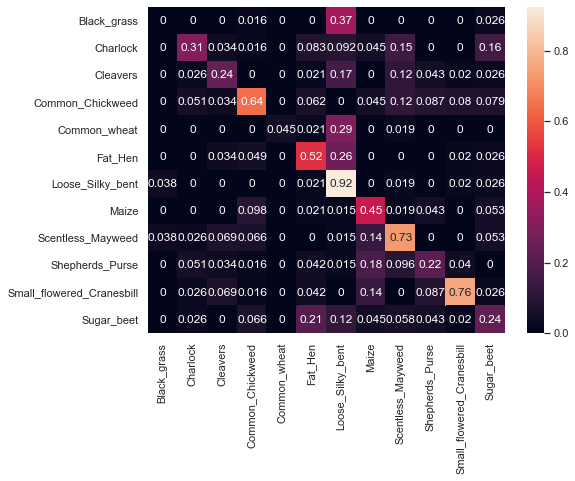

In [57]:
cf_matrix = confusion_matrix(y_test_e1, y_test_pred_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(8,6))
sns.heatmap(cf_matrix_n1, xticklabels=colsnew, yticklabels=colsnew, annot=True)

#### Observations
<p> The model can be improved, but it is still performing decent as seen above. </p>

In [100]:
#Model 2
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model = Sequential()
#
y_train_e=np.array(y_train_e)
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
#
model.add(Conv2D(filters = 32, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#
model.add(Conv2D(filters = 64, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# 
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 20  
batch_size = 10



es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history_model2=model.fit(X_train_final, 
          y_train_e,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=20, #number of iterations over the entire dataset to train on
          batch_size=10,validation_split=0.30,callbacks=[es, mc],use_multiprocessing=True)#number of samples per gradient update for training  



Epoch 1/20
300/300 [==============================] - ETA: 0s - loss: 2.4225 - accuracy: 0.1380
Epoch 00001: val_accuracy improved from -inf to 0.21980, saving model to best_model.h5
300/300 [==============================] - 71s 235ms/step - loss: 2.4225 - accuracy: 0.1380 - val_loss: 2.4022 - val_accuracy: 0.2198
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 2.1312 - accuracy: 0.2844
Epoch 00002: val_accuracy improved from 0.21980 to 0.34528, saving model to best_model.h5
300/300 [==============================] - 79s 263ms/step - loss: 2.1312 - accuracy: 0.2844 - val_loss: 1.9564 - val_accuracy: 0.3453
Epoch 3/20
300/300 [==============================] - ETA: 0s - loss: 1.8383 - accuracy: 0.3573
Epoch 00003: val_accuracy improved from 0.34528 to 0.37880, saving model to best_model.h5
300/300 [==============================] - 84s 280ms/step - loss: 1.8383 - accuracy: 0.3573 - val_loss: 1.7803 - val_accuracy: 0.3788
Epoch 4/20
300/300 [=======================

In [101]:
model.evaluate(X_test_final,np.array(y_test_e))

15/15 [==============================] - 2s 133ms/step - loss: 1.1986 - accuracy: 0.6000


[1.198637843132019, 0.6000000238418579]

## Observation
<p> CNN Model 2 which involved early stopping and dropout as well as maxpool had a training accuracy of 62.8% and accuracy of 60% on the test set. </p>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


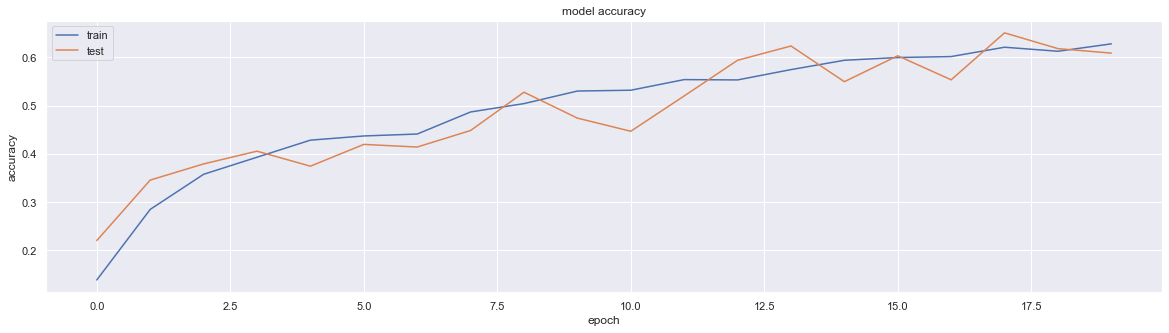

In [102]:
print(history_model2.history.keys())
# summarize history for accuracy
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Observation
<p> The curve shows that the train/test are close together, so overfitting is unlikely. However, since the curves are still increasing as epochs increase, it implies that the model that can be improved further. </p>

### Conclusion and key take aways
<p> The images dataset had 12 categories of plant seedlings and weeds. The mean images did not show much difference between the categories. </p>
<p> The grayscale images, while reducing the dimension of the image matrix (128 x 128 x 3 down to 128 x 128) resulted in images where it became harder to dicern the seedlings from their background. Usually, grayscale images present an advantage since they reduce the dimension of the images to be processed while retaining feature information. However, in this particular dataset, the original RGB dataset retained better visual contrast between the seedlings and the background. Hence, RGB images were used for the deep learning models. </p>
<p> Gaussian blurring was used to reduce noise in the image. Since the background had pebbles, blurring proved to be advantageous so that the edge differentiation was more pronounced between the seedling and the background, instead of edge presence between different pebbles in the background. </p>
<p> The first CNN model was a simplistic model consisting of convolution layers, dense layers but did not involve overfitting. The accuracy between training and testing was 65% and 51% respectively. </p>
<p> The second CNN model used 5 convolution layes, 2 dense layers (including the output) and also max pooling. Max pooling is useful since it pools set of features and also selects brighter pixels from the images. For our dataset, while both features the seedling pixels are brighter than the background, hence max pooling can be used. </p>
<p> Dropout was also utilized in the second CNN model. This procedure involves ignoring neurons during the training phase.While this technique is usually used to prevent overfitting, it was utilized here in CNN Model 2 (dropout of 0.25 and  0.3). </p>
<p> Overall, the CNN model 2 had an accuracy of 62.8% for training set and 60% for testing set. It can be interpreted that the model is not overfitting. This model performed better than CNN Model 1 since the accuracy on the testing set is higher and closer to the training set.  </p>
<p> However, several improvements to the model are possible - since both the models are sort of underfitting (not capturing all the informationn in the images) one can use data augmentation where the training data images are made to undergo a horizontal flip or a rotation so that the total number of images increases for training. This coupled with transfer training (where the weights are set using a pre-built architechture and only the last couple of layers are trainined). </p>
<p> Overall summary: model can be further improved to achieve greater accuracy on the training as well as testing set. The CNN model is time consuming, hence efficient architechtural design of the network will pay dividends. </p>
